# Preprocessing

In [257]:
import os

DATASET_NAME = "drsprg"
BASE_DIR = f"../data/processed/{DATASET_NAME}/"
IMAGES_DIR = os.path.join(BASE_DIR, "jpgs/")
DATASET = os.path.join(BASE_DIR, "data_list_export_120217.xlsx")

In [258]:
import cv2
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import islice
from pathlib import Path

## Preprocess data set

In [259]:
df = pd.read_excel(DATASET, index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 102 entries, 1 to 107
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   study_name  102 non-null    object
 1   gender      102 non-null    object
 2   age         102 non-null    int64 
 3   ckd         102 non-null    int64 
 4   lk          102 non-null    int64 
 5   scr         102 non-null    int64 
 6   crc         102 non-null    int64 
 7   mag3        102 non-null    int64 
 8   edta        102 non-null    int64 
 9   flood       102 non-null    int64 
dtypes: int64(8), object(2)
memory usage: 8.8+ KB


In [260]:
df["ckd"].unique()

array([1, 3, 2, 4, 5])

In [261]:
class_0_stages = [1, 2]
class_1_stages = [3, 4, 5]

In [262]:
df["label"] = df["ckd"].apply(lambda x: 0 if x in class_0_stages else 1)
df["label"].unique()

array([0, 1])

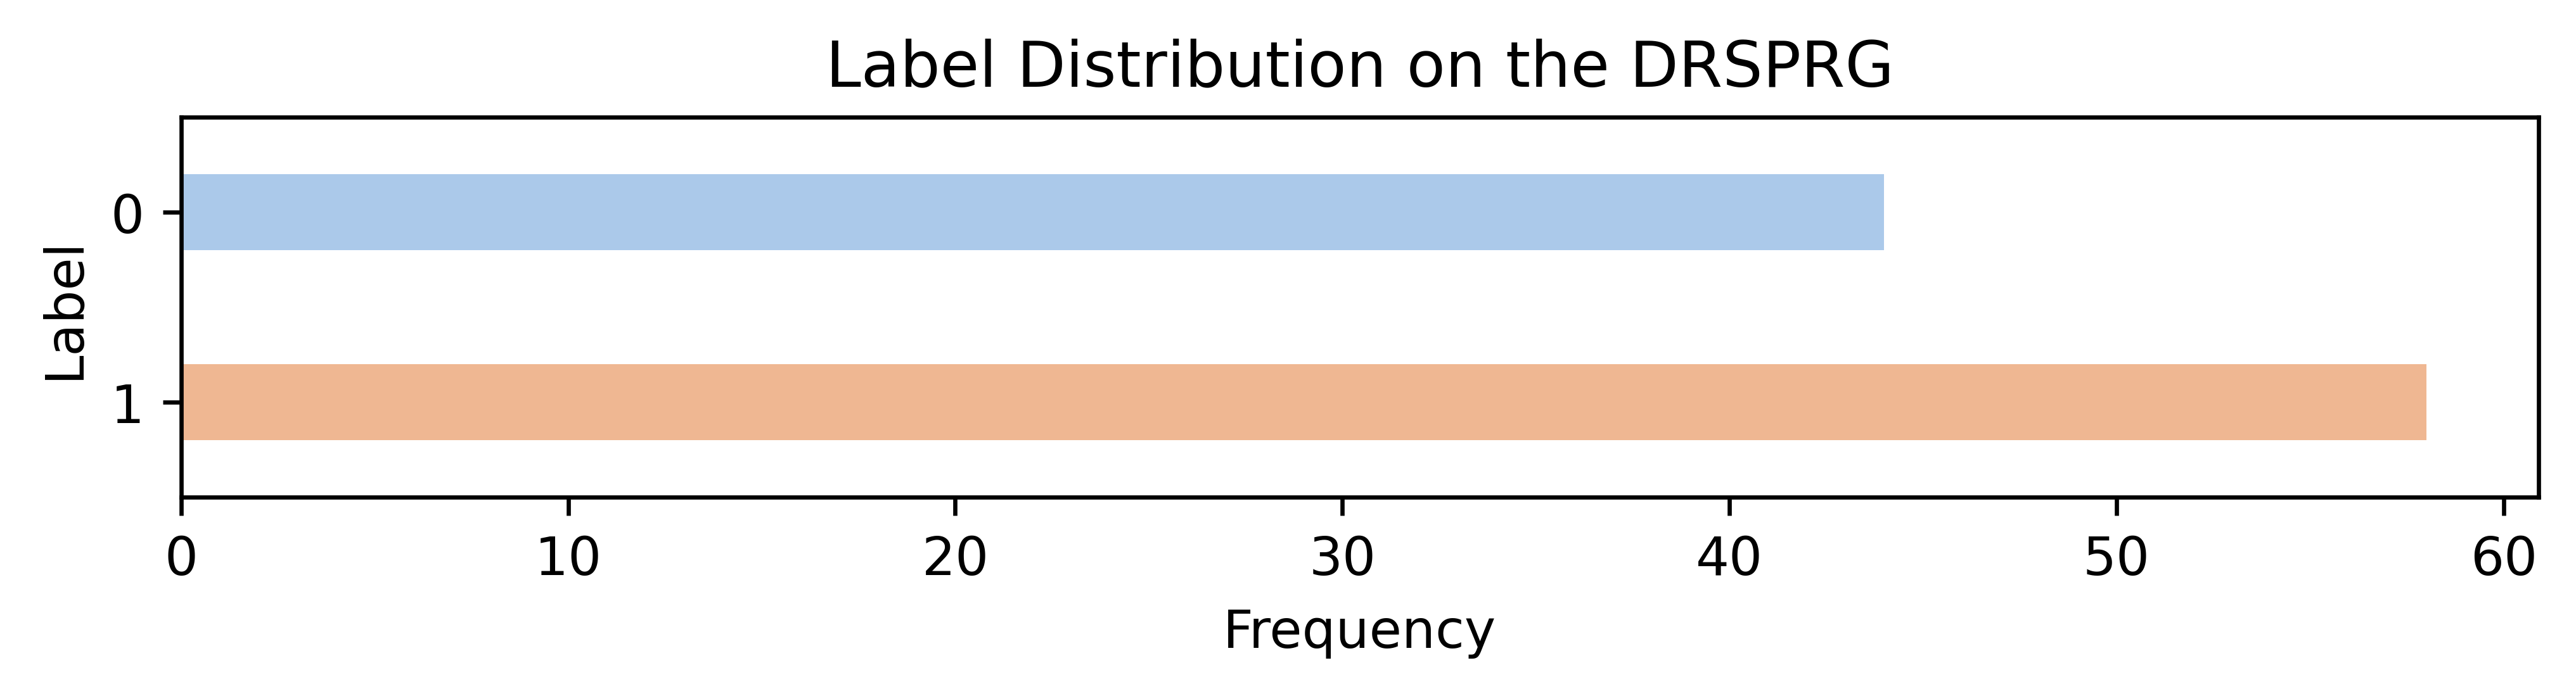

In [263]:
plt.figure(figsize=(8, 2), dpi=600)
sns.countplot(data=df, y="label", hue="label", width=0.4, palette="pastel", legend=False)
plt.title(f"Label Distribution on the {DATASET_NAME.upper()}")
plt.ylabel("Label")
plt.xlabel("Frequency")
plt.gcf().subplots_adjust(top=0.80)
plt.gcf().subplots_adjust(bottom=0.30)
plt.savefig(f"../images/{DATASET_NAME.lower()}_label_dist.pdf")
plt.show()

## Grouping scintigraphy images

In [264]:
REMOVE = {
    "ANT2",
    "POST2",
    "flood",
    "POST",
    "drsprg_025",
    "drsprg_055",
    "drsprg_065",
    "drsprg_081",
    "drsprg_106",
}


def filter_images(images_dir, group_size):

    def batched(iterable, n):
        if n < 1:
            raise ValueError("n must be at least one")
        it = iter(iterable)
        while batch := tuple(islice(it, n)):
            yield batch

    def key(x):
        splited = x.name.replace(".jpg", "").split("_")
        return int(splited[-3]), int(splited[-1])

    paths = sorted(Path(images_dir).glob("**/*.jpg"))
    filtered = [
        path
        for path in paths
        if all((unwanted not in path.name) for unwanted in REMOVE)
    ]
    filtered.sort(key=key)
    yield from batched(filtered, group_size)


image_path_groups = list(filter_images(IMAGES_DIR, 12))

In [265]:
assert len(image_path_groups) / 102 == 15

## Preprocess

### Blurring

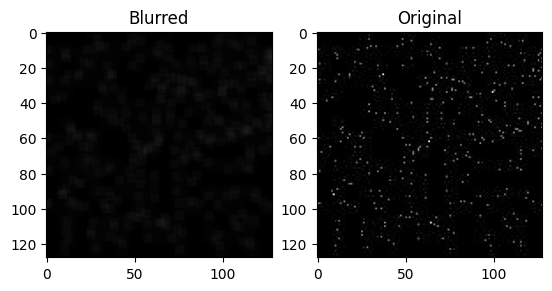

In [266]:
img = cv2.imread(str(image_path_groups[0][0]))
kernel = np.ones((5, 5), np.float32) / 25
dst = cv2.filter2D(img, -1, kernel)

plt.subplot(121)
plt.title("Blurred")
plt.imshow(dst)
plt.subplot(122)
plt.title("Original")
plt.imshow(img)
plt.show()